# 0.Import Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install yfinance
!pip install transformers

In [3]:
# basic packages
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
from datetime import timezone, timedelta
import datetime
import re
import yfinance as yf
import holidays
import pickle

In [4]:
# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [5]:
# tensorflow packages
import tensorflow as tf
import torch
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, GRU, RNN
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy as acc

In [6]:
# keras packages
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
# visualization packages
import math
import seaborn as sns
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [8]:
# FinBERT packages
from tensorflow.keras.layers.experimental import preprocessing
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

def SentimentAnalyzer(doc):
    pt_batch = tokenizer(doc,padding=True,truncation=True,max_length=512,return_tensors="pt")
    outputs = model(**pt_batch)
    pt_predictions = F.softmax(outputs.logits, dim=-1)
    return pt_predictions.detach().cpu().numpy()

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

# 1.Read and Concat Raw Data

In [9]:
# Data1: analyst ratings processed

# columns: title、date、ticker
data1 = pd.read_csv('/content/drive/MyDrive/Kaggle/Daily_Financial_News_for_6000_Stocks/datasets/analyst_ratings_processed.csv', index_col=0)
data1.dropna(inplace = True)
data1.rename(columns={'stock':'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x : x.split()[0])

In [10]:
data1.head()

,title,date,ticker
0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,A
1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,A
2.0,71 Biggest Movers From Friday,2020-05-26,A
3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,A
4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22,A


In [11]:
print(data1.shape)
print(data1.info())
print(data1.describe())

(1397891, 3)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 1397891 entries, 0.0 to 1413848.0
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1397891 non-null  object
 1   date    1397891 non-null  object
 2   ticker  1397891 non-null  object
dtypes: object(3)
memory usage: 42.7+ MB
None
                          title        date   ticker
count                   1397891     1397891  1397891
unique                   841164        3957     6192
top     Benzinga's Top Upgrades  2020-03-12      MRK
freq                       5349        2735     3334


In [12]:
# Data2: us equities news dataset

# columns: title、date、ticker
data2 = pd.read_csv('/content/drive/MyDrive/Kaggle/Daily_Financial_News_for_6000_Stocks/datasets/us_equities_news_dataset.csv', index_col=0)
data2.dropna(inplace = True)
data2.reset_index(drop=True, inplace=True)
data2.rename(columns={'release_date':'date'}, inplace=True)
data2.drop(inplace=True, columns=['category', 'content', 'provider', 'url', 'article_id'], axis=1)

In [14]:
data2.head()

,ticker,title,date
0,NIO,Why Shares of Chinese Electric Car Maker NIO A...,2020-01-15
1,NIO,NIO only consumer gainer Workhorse Group amon...,2020-01-18
2,NIO,NIO leads consumer gainers Beyond Meat and Ma...,2020-01-15
3,NIO,NIO NVAX among premarket gainers,2020-01-15
4,NIO,PLUG NIO among premarket gainers,2020-01-06


In [15]:
print(data2.shape)
print(data2.info())
print(data2.describe())

(221505, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221505 entries, 0 to 221504
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ticker  221505 non-null  object
 1   title   221505 non-null  object
 2   date    221505 non-null  object
dtypes: object(3)
memory usage: 5.1+ MB
None
        ticker                             title        date
count   221505                            221505      221505
unique     802                            215439        3641
top       AAPL  Day Ahead  Top 3 Things to Watch  2020-01-30
freq     20231                               203         505


In [33]:
data = pd.concat([data1, data2])

# remove rows whose title is duplicated
data.drop_duplicates(subset='title', keep='first', inplace=True)

In [34]:
print(data.head(5))
print(data.shape)
print(data.info())
print(data.describe())

                                                 title        date ticker
0.0            Stocks That Hit 52-Week Highs On Friday  2020-06-05      A
1.0         Stocks That Hit 52-Week Highs On Wednesday  2020-06-03      A
2.0                      71 Biggest Movers From Friday  2020-05-26      A
3.0       46 Stocks Moving In Friday's Mid-Day Session  2020-05-22      A
4.0  B of A Securities Maintains Neutral on Agilent...  2020-05-22      A
(1056471, 3)
<class 'pandas.core.frame.DataFrame'>
Float64Index: 1056471 entries, 0.0 to 221504.0
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   title   1056471 non-null  object
 1   date    1056471 non-null  object
 2   ticker  1056471 non-null  object
dtypes: object(3)
memory usage: 32.2+ MB
None
                                          title        date   ticker
count                                   1056471     1056471  1056471
unique                                  1056471     

# 2.Data Preprocessing

## 2-1.Define Data Range

In [35]:
# time range: 2014~2020
data = data[data['date'] > '2014-05-31']

In [36]:
'''
Get financial text from different industries. In this kernel, 
we use a represent ETF of the IT industry, VGT, as a sample. 
Try XLF、XLY by using the same code.
'''

all_industry = []

IT = (('IT','VGT','1'),['AAPL', 'MSFT', 'NVDA', 'V', 'MA', 'AVGO', 'CSCO', 'ADBE', 'CRM', 'AMD']) # Information Technology(Top 10 holdings)
# Financials = (('Financials','XLF','2'),['BRK', 'JPM', 'BAC', 'WFC', 'SPGI', 'SCHW', 'MS', 'AXP', 'GS', 'BLK']) # Financials(Top 10 holdings)
# Consumer_Discretionary = (('Consumer Discretionary','XLY','3'),['AMZN', 'TSLA', 'MCD', 'HD', 'NKE', 'LOW', 'SBUX', 'TGT', 'BKNG', 'TJX']) # Consumer Discretionary(Top 10 holdings)

all_industry.append(IT)
# all_industry.append(Financials)
# all_industry.append(Consumer_Discretionary) 


## 2-2.Feature Engineering

In [37]:
# create a dataframe for all industries
dataIndustry = pd.DataFrame()

# gget all news titles of top 10 holdings as ETF's historical financial text
for industry in all_industry:
    for tickerSymbol in industry[1]:
        dataTicker = data[data['ticker']==tickerSymbol]
        dataTicker['etf'] = industry[0][1]
        dataTicker['etf-code'] = industry[0][2]
        dataIndustry = dataIndustry.append(dataTicker, ignore_index = True)

dataIndustry

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,title,date,ticker,etf,etf-code
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,VGT,1
1,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,VGT,1
2,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,VGT,1
3,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,VGT,1
4,Big Tech Reaches New Record Heights At The Sto...,2020-06-10,AAPL,VGT,1
...,...,...,...,...,...
34742,4 Stocks To Watch NTRA OLED SLCA SUPN,2016-05-24,AMD,VGT,1
34743,Tuesday s Pre Market Insights AMD BBRY LULU,2015-06-09,AMD,VGT,1
34744,AMD Here s Why It s Climbing,2016-03-02,AMD,VGT,1
34745,AMD Here s Why Investors Are Excited,2016-03-17,AMD,VGT,1


In [44]:
# group by ETF
dataGroup = dataIndustry.groupby("etf")

In [40]:
# combine all titles which in the same day
def combin_date_news_ETFs(dataIndustry,rowdata):
  etf = rowdata[0]
  data = rowdata[1]

  etf_uniqueDates = list(set(data['date'].tolist()))
  print("The number of {}'s unique date : {}".format(etf,len(etf_uniqueDates)))

  date_ud = []
  tts = []

  tmpData = {}
  for ud in tqdm(etf_uniqueDates):
      titles = dataIndustry[dataIndustry['date'] == ud]['title'].tolist()
      date_ud.append(ud)
      tts.append(titles)
      tmpData[ud] = titles

  data = pd.DataFrame(columns =['date'], data=date_ud)
  data['titles'] = np.array(tts)
  data['etf'] = etf
  return data

In [41]:
# save results as a list
data_ETFs = []
for rowdata in dataGroup:
  data = combin_date_news_ETFs(dataIndustry,rowdata)
  data_ETFs.append(data)
print(len(data_ETFs))

data_ETFs

The number of VGT's unique date : 2039


100%|██████████| 2039/2039 [00:06<00:00, 322.05it/s]

1



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[            date                                             titles  etf
 0     2015-06-28  [Weekly Earnings Update  Forward Estimate To  ...  VGT
 1     2018-09-13  [Fidelity Investments winds down  3 5 billion ...  VGT
 2     2016-05-13  [Apple  Chinese rideshare deal heats up race f...  VGT
 3     2016-12-14  [Trump team says Twitter too small to be inclu...  VGT
 4     2014-10-29  [Visa sees mobile payment as big growth driver...  VGT
 ...          ...                                                ...  ...
 2034  2016-05-09  [Facebook beverages won t be a thing in China ...  VGT
 2035  2019-04-08  [EU s Vestager says Europe must lead the way w...  VGT
 2036  2014-12-26  [U S  retailers miss fewer Christmas deadlines...  VGT
 2037  2020-04-30  [Apple CEO Tim Cook: Store Traffic Not Back To...  VGT
 2038  2014-08-28  [New iPhones expected at Sept  9 Apple event, ...  VGT
 
 [2039 rows x 3 columns]]

In [42]:
# key:today#etf, value:financial text
def get_sentiment_analysis_input(data_ETFs):
  inputData = {}
  etfs = []
  for data in data_ETFs:
    dates = list(data['date'])
    titles = list(data['titles'])
    etf = list(data['etf'])[0]
    etfs.append(etf)
    print("Length => date:{}, title:{}".format(str(len(dates)),str(len(titles))))
    for date, title in zip(dates,titles):
      inputData[date+"#"+etf] = title
      # inputData[etf] = {date:title}
  return inputData,etfs

inputData, etfs = get_sentiment_analysis_input(data_ETFs)

Length => date:2039, title:2039


In [43]:
# check the data
from itertools import islice
dict(islice(inputData.items(), 100, 101))

{'2017-02-28#VGT': ['Apple says it spent  50 billion last year with U S  suppliers',
  'Disruption in Amazon s cloud service ripples through internet',
  'SPX Limping Higher',
  'Amazon To Release Season 2 Of Sky Drama Series Fortitude',
  'Xbox unveils  9 99 monthly subscription for videogames',
  'Buffett s Berkshire rejects fossil fuel proposal  shareholder says',
  'Salesforce com forecasts lower than expected Q1 profit  shares fall',
  '5 Stocks To Watch After The U S  Close',
  '2017 Game Developers Conference Continues Today, Day 2 Of 5',
  'Former FIFA secretary general Valcke appeals 10 year soccer ban',
  'Saudi Telecom, Cisco Sign Managed Services Agreement',
  'Morgan Stanley Tech, Media & Telecom Conf. Continues Today; Presenters Include RingCentral, Cisco, Atlassian, Adobe, Ultimate Software, Impinj, Zendesk, Intuit, & Verizon',
  "William Blair Maintains Outperform on salesforce Following Earnings, Calls Q4 Results 'Strong,' Highlights 'Billings Above Expectations'",
  "

## 2-3.Calculating Sentiment Scores

In [45]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()
# business day only
def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

In [46]:
# calculating three sentiment scores by FinBERT
def findPercentageBySentences(sentenceList):
    posAvg, negAvg, neuAvg = 0, 0, 0
    sentimentArr = SentimentAnalyzer(sentenceList)
    sentimentArr = np.mean(sentimentArr, axis=0)
    posAvg=sentimentArr[0]
    negAvg=sentimentArr[1]
    neuAvg=sentimentArr[2]
    return {'numArticles': len(sentenceList), 'pos': posAvg, 'neg': negAvg, 'neu' : neuAvg}

In [47]:
dateSentimentGroups = {}
for unique_date_etf in tqdm(inputData):
    # input sentences in a list for getting scores 
    scores = findPercentageBySentences(inputData[unique_date_etf])
    # save results as a dict
    dateSentimentGroups[unique_date_etf] = scores

100%|██████████| 2039/2039 [1:12:24<00:00,  2.13s/it]


In [55]:
len(dateSentimentGroups)

2039

## 2-4.Processing After Getting Sentiment Scores

In [56]:
# columns of df: titles、three scores、opne and close price、 VTI's opne and close price 
def add_stock_price(etfs,dateSentimentGroups):
  data = []

  hist_etfs = {}
  for etf in etfs:
    ticker = yf.Ticker(etf)
    hist_etfs[etf] = ticker.history(period="max")

  ticker_vti = yf.Ticker("VTI")
  hist_vti = ticker_vti.history(period="max")

  for i in tqdm(dateSentimentGroups):
      start = i.split("#")[0]
      etf = i.split("#")[1]
      
      nextDay = next_business_day(start).strftime("%Y-%m-%d")
      try:
          prevDay = hist_etfs[etf].loc[start]
          prevDayVTI = hist_vti.loc[start]
          nextDay = hist_etfs[etf].loc[nextDay]

          data.append([i, dateSentimentGroups[i]['numArticles'], dateSentimentGroups[i]['neu'], dateSentimentGroups[i]['pos'], dateSentimentGroups[i]['neg'], prevDay['Open'], prevDay['Close'], prevDayVTI['Open'], prevDayVTI['Close']])
      except:
          pass
  return data

In [85]:
data = add_stock_price(etfs,dateSentimentGroups)
# data

100%|██████████| 2039/2039 [00:02<00:00, 945.77it/s]


In [79]:
# set column names
df = pd.DataFrame(columns =['DateTemp', 'NumArticles', 'Neutral', 'Positive','Negative','Open', 'Close', 'Open-VTI', 'Close-VTI'], data=data)
df.head()

,DateTemp,NumArticles,Neutral,Positive,Negative,Open,Close,Open-VTI,Close-VTI
0,2018-09-13#VGT,29,0.517663,0.248372,0.233965,193.398732,194.418137,140.732666,140.910965
1,2016-05-13#VGT,28,0.622514,0.225210,0.152276,97.951238,97.716972,94.545374,93.951538
2,2016-12-14#VGT,16,0.471205,0.348064,0.180731,116.869586,116.453072,106.686472,105.769264
3,2014-10-29#VGT,4,0.193451,0.472619,0.333930,91.971199,91.906723,89.495601,89.242294
4,2017-07-06#VGT,29,0.493412,0.253830,0.252758,133.380355,133.142380,114.752088,114.032814


In [80]:
# split "Date" and "ETF" from "DateTemp"
date = [d[0] for d in df['DateTemp'].str.split('#')]
etf = [d[1] for d in df['DateTemp'].str.split('#')]
df['Date'] = np.array(date)
df['ETF'] = np.array(etf)
df = df.drop(['DateTemp'], axis=1)

In [81]:
# sort values by date because it's a time series research
df = df.sort_values(by=['Date'])
df

,NumArticles,Neutral,Positive,Negative,Open,Close,Open-VTI,Close-VTI,Date,ETF
1303,3,0.344139,0.076766,0.579096,86.592039,86.260445,86.419339,86.332741,2014-06-02,VGT
812,4,0.303411,0.064673,0.631916,85.910391,86.186722,86.116291,86.298141,2014-06-03,VGT
872,4,0.744701,0.220179,0.035120,85.965687,86.435440,86.055642,86.479950,2014-06-04,VGT
450,5,0.554678,0.320903,0.124419,86.555165,87.218353,86.609844,87.181358,2014-06-05,VGT
134,6,0.482616,0.267740,0.249644,87.374962,87.678925,87.449779,87.631622,2014-06-06,VGT
...,...,...,...,...,...,...,...,...,...,...
1296,8,0.508031,0.319348,0.172621,261.554759,259.920715,153.214775,153.350784,2020-06-04,VGT
292,20,0.397332,0.564804,0.037864,261.889449,266.200958,156.799560,157.285309,2020-06-05,VGT
1460,4,0.336048,0.631572,0.032380,265.974503,267.834930,158.256815,159.422623,2020-06-08,VGT
493,11,0.499317,0.471473,0.029210,266.387936,268.435425,158.013956,157.965393,2020-06-09,VGT


In [82]:
dfGroup = df.groupby("ETF")
print(len(dfGroup))
print(list(dfGroup))

1
[('VGT',       NumArticles   Neutral  Positive  Negative        Open       Close  \
1303            3  0.344139  0.076766  0.579096   86.592039   86.260445   
812             4  0.303411  0.064673  0.631916   85.910391   86.186722   
872             4  0.744701  0.220179  0.035120   85.965687   86.435440   
450             5  0.554678  0.320903  0.124419   86.555165   87.218353   
134             6  0.482616  0.267740  0.249644   87.374962   87.678925   
...           ...       ...       ...       ...         ...         ...   
1296            8  0.508031  0.319348  0.172621  261.554759  259.920715   
292            20  0.397332  0.564804  0.037864  261.889449  266.200958   
1460            4  0.336048  0.631572  0.032380  265.974503  267.834930   
493            11  0.499317  0.471473  0.029210  266.387936  268.435425   
476             8  0.405064  0.444896  0.150040  270.512459  272.431976   

        Open-VTI   Close-VTI        Date  ETF  
1303   86.419339   86.332741  2014-06-02

# 3.Model Creating

## 3-1.define functions

In [83]:
# add label
predict_day = -5
def calculate_Close(df,predict_day):
  df['Close_N_days'] = df['Close'].shift(predict_day)
  df = df.dropna()
  return df

VGT = calculate_Close(df,predict_day)
VGT

,NumArticles,Neutral,Positive,Negative,Open,Close,Open-VTI,Close-VTI,Date,ETF,Close_N_days
1303,3,0.344139,0.076766,0.579096,86.592039,86.260445,86.419339,86.332741,2014-06-02,VGT,87.955223
812,4,0.303411,0.064673,0.631916,85.910391,86.186722,86.116291,86.298141,2014-06-03,VGT,88.121040
872,4,0.744701,0.220179,0.035120,85.965687,86.435440,86.055642,86.479950,2014-06-04,VGT,88.028915
450,5,0.554678,0.320903,0.124419,86.555165,87.218353,86.609844,87.181358,2014-06-05,VGT,87.273628
134,6,0.482616,0.267740,0.249644,87.374962,87.678925,87.449779,87.631622,2014-06-06,VGT,87.826302
...,...,...,...,...,...,...,...,...,...,...,...
909,13,0.365633,0.227779,0.406588,253.561744,253.778305,150.008815,148.833298,2020-05-28,VGT,259.920715
1156,6,0.442586,0.208929,0.348485,254.398504,256.947998,148.444715,149.328781,2020-05-29,VGT,266.200958
143,10,0.409521,0.251517,0.338962,255.914352,257.774780,149.241330,150.339127,2020-06-01,VGT,267.834930
67,10,0.386972,0.245035,0.367993,258.266994,260.078217,150.776305,151.475784,2020-06-02,VGT,268.435425


In [84]:
all_df = []
all_df.append(VGT)

In [69]:
# seperate the data as training/test and validation
def df_separate(df, separateBy):
  df1 = df[df['Date'] <= separateBy]
  df2 = df[df['Date'] > separateBy]
  return df1, df2

In [70]:
# transform features and label to np.array and reshape it for model
def colToNumpy(df,col_names):
  return df[col_names].to_numpy().reshape(len(df), len(col_names))

In [71]:
# get training and test data (time series)
# "window" => to control how many days of historical financial test to calculate sentiment scores
def get_train_test(df_scaled, label_idx=8, window=5, test_size=0.2):
  X, Y = [],[]
  for i in range(window,len(df_scaled)):
    # features: historical sentiment scores and open/close prices
    X.append(df_scaled[i-window : i, 0 : label_idx])
    # label: close price after five days
    Y.append(df_scaled[i, label_idx])

  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
  return np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

In [72]:
# used LSTM-GRU model
def build_and_compile_LSTM_GRU(train_X,label_idx=8,dropout=0.4):
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], label_idx)))
  model.add(Dropout(dropout))

  model.add(GRU(units=50, return_sequences=True, activation='tanh'))
  model.add(Dropout(dropout))

  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(dropout))
  
  model.add(GRU(units=50, activation='tanh'))
  model.add(Dropout(dropout))

  model.add(Dense(units=1))
  
  model.compile(optimizer='adam',loss='mean_squared_error', metrics=['mae'])
  return model

## 3-2.Training and Evaluation

In [73]:
def model_evaluation(model, history, train_X, test_X, test_Y):
  preds = model.predict(test_X)
  preds = np.squeeze(preds, axis=1)

  RMSE= np.sqrt(mean_squared_error(test_Y, preds))
  MAE = mean_absolute_error(test_Y, preds)
  R2 = r2_score(test_Y, preds)
  n = len(test_X) 
  p = train_X.shape[2]
  adj_r2 =  1-(1-R2)*(n-1)/(n-p-1)

  print("MAE:{}, RMSE:{}".format(MAE,RMSE)) 
  print("r2:{}, adj_r2:{}".format(R2,adj_r2))
  print("="*50)
  plt.plot(history.history['loss'], label='train loss')
  plt.plot(history.history['val_loss'], label='val loss')
  plt.xlabel("epoch")
  plt.ylabel("Loss")
  plt.legend()

In [74]:
# set features
col_names = ['NumArticles','Neutral','Positive','Negative','Open','Close','Open-VTI','Close-VTI','Close_N_days']
# set folder path
folder_path = '/content/drive/MyDrive/Kaggle/Daily_Financial_News_for_6000_Stocks/'

In [75]:
def model_train(df, col_names, folder_path, separateDate="2020-04-30", epochs=200, batch_size=5):
  etf = df['ETF'][0]
  df1, df2 = df_separate(df, separateDate)
  raw = colToNumpy(df1,col_names)
  train_X, test_X, train_Y, test_Y = get_train_test(raw)

  model = build_and_compile_LSTM_GRU(train_X)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
  history = model.fit(train_X, train_Y, validation_data=(test_X, test_Y), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[es])
  model_evaluation(model, history, train_X, test_X, test_Y)

  tz = timezone(timedelta(hours=+8))
  doneTime = datetime.datetime.now(tz).isoformat().split(".")[0].replace("-","").replace(":","").replace("T","_")
  model.save(folder_path + "models/model_vgt.h5".format(etf,doneTime))

Epoch 1/200
237/237 [==============================] - 15s 23ms/step - loss: 19523.4512 - mae: 131.3417 - val_loss: 18243.1562 - val_mae: 126.6692
Epoch 2/200
237/237 [==============================] - 4s 16ms/step - loss: 16489.5508 - mae: 119.1667 - val_loss: 15632.3057 - val_mae: 115.9061
Epoch 3/200
237/237 [==============================] - 4s 18ms/step - loss: 14109.9229 - mae: 108.7668 - val_loss: 13367.9717 - val_mae: 105.6877
Epoch 4/200
237/237 [==============================] - 6s 24ms/step - loss: 12020.6865 - mae: 98.5919 - val_loss: 11407.4902 - val_mae: 95.9657
Epoch 5/200
237/237 [==============================] - 5s 23ms/step - loss: 10243.4170 - mae: 89.2654 - val_loss: 9722.6533 - val_mae: 86.7443
Epoch 6/200
237/237 [==============================] - 6s 24ms/step - loss: 8698.2354 - mae: 80.0561 - val_loss: 8286.6631 - val_mae: 78.0294
Epoch 7/200
237/237 [==============================] - 5s 22ms/step - loss: 7536.9121 - mae: 71.9172 - val_loss: 7068.5664 - val_mae

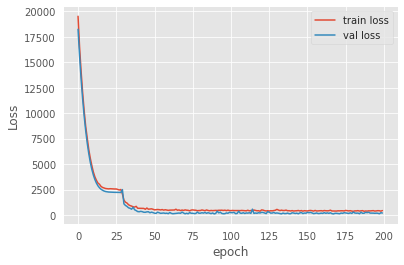

In [76]:
for df in all_df:
  model_train(df,col_names,folder_path)